In [6]:
import xgboost as xgb
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd

In [10]:
# Load adversarial data
adv_train = pd.read_csv("data/adversarial_train_samples.csv")
adv_test = pd.read_csv("data/adversarial_test_samples.csv")

# Assuming the last column is the label and the rest are features
x_train_adv = adv_train.iloc[:, :-1]  # Features
y_train_adv = adv_train.iloc[:, -1]   # Labels
x_test_adv = adv_test.iloc[:, :-1]    # Features
y_test_adv = adv_test.iloc[:, -1]     # Labels

In [11]:
# Define XGBoost parameters to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_model_adv = xgb.XGBClassifier(eval_metric='mlogloss')

# Set up GridSearchCV
grid_search_adv = GridSearchCV(estimator=xgb_model_adv, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV with adversarial data
grid_search_adv.fit(x_train_adv, y_train_adv)

# Get the best model
best_model_adv = grid_search_adv.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [12]:
# Evaluate the best model on adversarial test data
y_pred_adv = best_model_adv.predict(x_test_adv)
print("Classification Report (Adversarial Data):\n", classification_report(y_test_adv, y_pred_adv))

# Save the best model
joblib.dump(best_model_adv, 'best_xgboost_adversarial_model.pkl')

print("Best adversarial model saved successfully.")

Classification Report (Adversarial Data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Best adversarial model saved successfully.


Classification Report (Adversarial Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Confusion Matrix (Adversarial Data):
[[56841    22]
 [   16 56847]]


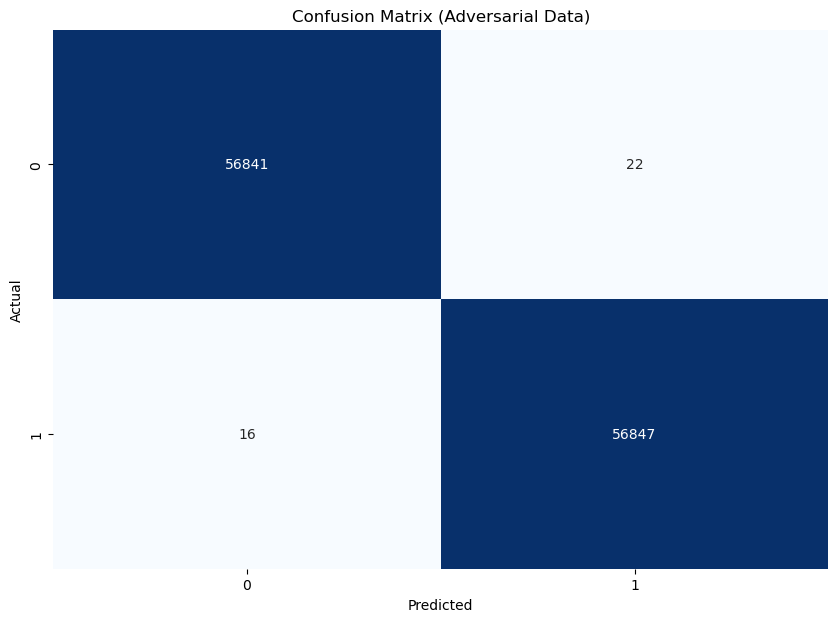

ROC AUC Score (Adversarial Data): 0.9999989627020467


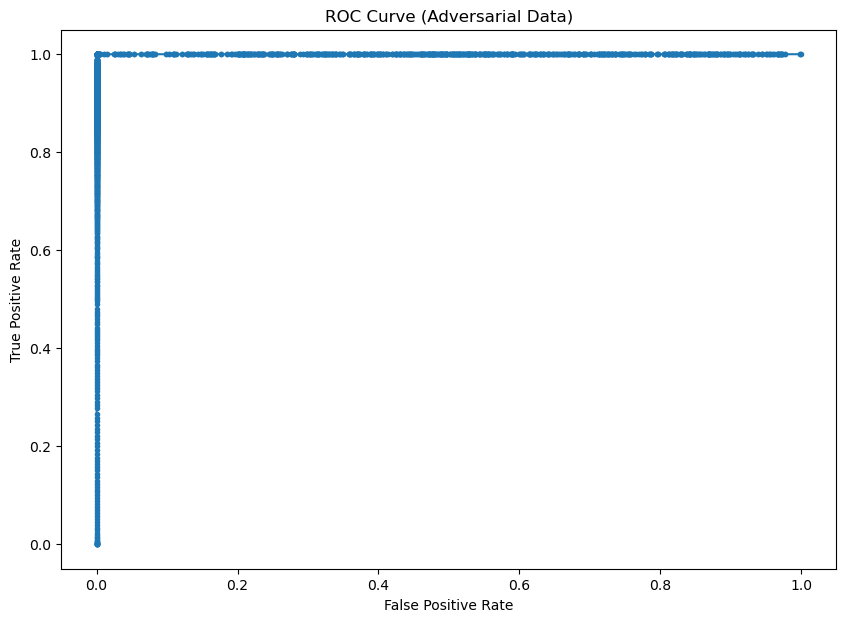

In [15]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# Load the adversarial datasets
adv_test = pd.read_csv("data/adversarial_test_samples.csv")

# Assuming the last column is the label and the rest are features
x_test_adv = adv_test.iloc[:, :-1]  # Features
y_test_adv = adv_test.iloc[:, -1]   # Labels

# Ensure labels are properly formatted
y_test_adv_np = y_test_adv.squeeze().values

# Load the adversarial XGBoost model from .pkl file
with open('best_xgboost_adversarial_model.pkl', 'rb') as f:
    model_adv = pickle.load(f)

# Make predictions
y_pred_prob_adv = model_adv.predict_proba(x_test_adv)[:, 1]  # Probabilities for the positive class
y_pred_adv = (y_pred_prob_adv > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute metrics
print("Classification Report (Adversarial Data):")
print(classification_report(y_test_adv_np, y_pred_adv))

print("Confusion Matrix (Adversarial Data):")
cm_adv = confusion_matrix(y_test_adv_np, y_pred_adv)
print(cm_adv)

# Plot Confusion Matrix (Adversarial Data)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Adversarial Data)')
plt.show()

# ROC AUC (Adversarial Data)
roc_auc_adv = roc_auc_score(y_test_adv_np, y_pred_prob_adv)
print(f'ROC AUC Score (Adversarial Data): {roc_auc_adv}')

# ROC Curve (Adversarial Data)
fpr_adv, tpr_adv, _ = roc_curve(y_test_adv_np, y_pred_prob_adv)
plt.figure(figsize=(10, 7))
plt.plot(fpr_adv, tpr_adv, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adversarial Data)')
plt.show()